# Jupiter notebook for the eleventh seminar

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import trange, tqdm
%config InlineBackend.figure_format = 'svg' 
from pylab import rcParams
rcParams['figure.figsize'] = 8,5
%matplotlib inline

In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import tensorflow_datasets as tfds
print("Version of tensorflow:",tf.__version__)
import sys
from IPython.display import clear_output

Version of tensorflow: 2.7.0


## Latent space interpolation

In [3]:
# Download MNIST dataset
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
X_train = (X_train / 255).astype('float32')
X_test  = (X_test  / 255).astype('float32')

11501568/11490434 [==============================] - 0s 0us/step


In [4]:
# Function for data representation
def plot100(imgs):
  """
  Takes an image of size (100, None, None) and draws it
  """
  plt.imshow(
      np.array(imgs).reshape(
          (10, 10) + imgs.shape[1:3]
      ).transpose(0, 2, 1, 3).reshape(np.array(imgs.shape[1:]) * 10),
      cmap = "gray"
  )
  plt.axis('off')

The numbers: [2 0 9 1 8 1 6 0 3 0 4 9 8 1 0 0 5 3 2 0 3 2 6 9 2 3 4 4 0 6 0 2 2 0 9 7 0
 8 7 2 4 5 8 5 2 9 5 4 2 2 8 1 6 2 2 0 5 8 5 8 8 8 8 9 2 8 1 1 9 6 3 1 2 0
 8 1 0 1 0 6 8 2 0 8 9 8 1 7 6 4 4 5 6 3 5 1 5 5 9 5]


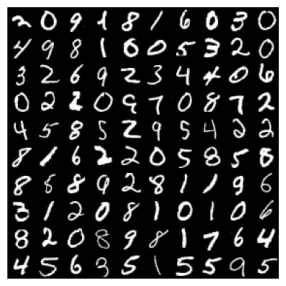

In [10]:
# Have a look at the elements
plt.figure(figsize=(10, 5), dpi=100)
numberOfElement = np.random.randint(0, len(X_train), 100)
print("The numbers:",y_train[numberOfElement])
plot100(X_train[numberOfElement]);

In [6]:
# Autoencoder architecture
ll = tf.keras.layers
activation = tf.nn.relu

encoder = tf.keras.Sequential([
    ll.Reshape((28, 28, 1), input_shape=(28, 28)),

    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 14x14

    ll.Conv2D(32, 3, padding='same', activation=activation),
    ll.MaxPool2D(), # 7x7

    ll.Conv2D(64, 3, padding='valid', activation=activation), # 5x5
    ll.Conv2D(128, 3, padding='valid', activation=activation), # 3x3
    ll.Conv2D(256, 3, padding='valid', activation=activation), # 1x1
    ll.Conv2D(32, 1, padding='same', activation=activation),

    ll.Reshape((32,))
  ],
  name='encoder')

decoder = tf.keras.Sequential([
    ll.Reshape((1, 1, 32), input_shape=(32,)),

    ll.UpSampling2D(), # 2x2
    ll.Conv2D(256, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 4x4
    ll.Conv2D(128, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 8x8
    ll.Conv2D(64, 3, padding='same', activation=activation),

    ll.UpSampling2D(), # 16x16
    ll.Conv2D(32, 3, padding='valid', activation=activation), # 14x14

    ll.UpSampling2D(), # 28x28
    ll.Conv2D(16, 3, padding='same', activation=activation),
    ll.Conv2D(1, 1, padding='valid', activation=activation),

    ll.Reshape((28, 28))
  ],
  name='decoder')

autoencoder = tf.keras.Sequential([
  encoder,
  decoder
])

autoencoder.summary()
autoencoder.compile(optimizer=tf.optimizers.Adam(), loss=tf.keras.losses.MSE)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Sequential)        (None, 32)                400544    
                                                                 
 decoder (Sequential)        (None, 28, 28)            465921    
                                                                 
Total params: 866,465
Trainable params: 866,465
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Fit of autoencoder
autoencoder.fit(x=X_train, y=X_train, batch_size=256, epochs=16, validation_data=(X_test, X_test));

Epoch 1/16
235/235 [==============================] - 246s 1s/step - loss: 0.0554 - val_loss: 0.0309
Epoch 2/16
235/235 [==============================] - 245s 1s/step - loss: 0.0224 - val_loss: 0.0176
Epoch 3/16
235/235 [==============================] - 245s 1s/step - loss: 0.0155 - val_loss: 0.0137
Epoch 4/16
235/235 [==============================] - 247s 1s/step - loss: 0.0127 - val_loss: 0.0120
Epoch 5/16
235/235 [==============================] - 247s 1s/step - loss: 0.0110 - val_loss: 0.0106
Epoch 6/16
235/235 [==============================] - 249s 1s/step - loss: 0.0098 - val_loss: 0.0095
Epoch 7/16
235/235 [==============================] - 249s 1s/step - loss: 0.0090 - val_loss: 0.0088
Epoch 8/16
235/235 [==============================] - 250s 1s/step - loss: 0.0084 - val_loss: 0.0084
Epoch 9/16
235/235 [==============================] - 250s 1s/step - loss: 0.0080 - val_loss: 0.0082
Epoch 10/16
235/235 [==============================] - 250s 1s/step - loss: 0.0076 - val_lo

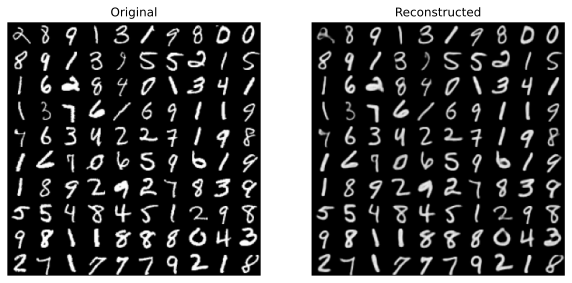

In [9]:
# Check the accuracy of the model
idx = np.random.randint(len(X_test), size=100)
rec_X_test = autoencoder(X_test, training=False).numpy()

plt.figure(figsize=(10, 5), dpi=100)
plt.subplot(1, 2, 1)
plt.title("Original")
plot100(X_test[idx])
plt.subplot(1, 2, 2)
plt.title("Reconstructed")
plot100(rec_X_test[idx])

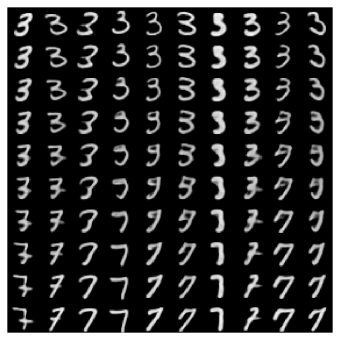

In [33]:
digit_1 = 3
digit_2 = 7

# Let's take 10 images of digit_1 and digit_2:
indices_1 = np.random.randint(0, X_test[y_test == digit_1].shape[0], 10)
indices_2 = np.random.randint(0, X_test[y_test == digit_2].shape[0], 10)
digits_1 = X_test[y_test == digit_1][indices_1]
digits_2 = X_test[y_test == digit_2][indices_2]

# Calculate the encoded representations of these digits:
representation_1 = encoder(digits_1, training=False).numpy()
representation_2 = encoder(digits_2, training=False).numpy()
difference = representation_2 - representation_1

# Now create a 10x10x<BOTTLENECK_SIZE> matrix of linear interpolations between
# the two representations:
zero_matrix = np.zeros((10, 10, 32), dtype=int)
spacial_resolution = np.linspace(0, 1, 10)
alpha = spacial_resolution[:,None,None] + zero_matrix
representation_mixed = (representation_1[None,:,:] + alpha * difference[None,:,:]).reshape(100, 32)

# Then decode the images from the mixed representations:
mixed_imgs = decoder(representation_mixed, training=False).numpy()

plt.figure(figsize=(6, 6), dpi=200)
plot100(mixed_imgs)